<a href="https://colab.research.google.com/github/luckyferbiansah89/Disease_Symptoms_Classification/blob/main/TK2_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ======================
# 1. Import Library
# ======================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
# ==========================
# 1.1 Get Files From Github
# ==========================
!wget https://raw.githubusercontent.com/luckyferbiansah89/Disease_Symptoms_Classification/main/dataset/dataset.csv
!wget https://raw.githubusercontent.com/luckyferbiansah89/Disease_Symptoms_Classification/main/dataset/Symptom-severity.csv

--2025-07-04 08:44:37--  https://raw.githubusercontent.com/luckyferbiansah89/Disease_Symptoms_Classification/main/dataset/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632202 (617K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>] 617.38K  --.-KB/s    in 0.07s   

2025-07-04 08:44:37 (8.87 MB/s) - ‘dataset.csv’ saved [632202/632202]

--2025-07-04 08:44:37--  https://raw.githubusercontent.com/luckyferbiansah89/Disease_Symptoms_Classification/main/dataset/Symptom-severity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request 

In [11]:
# ========================================
# 2 Load Dataset and check for duplicate
# ========================================

# Load dataset utama
df_raw = pd.read_csv("/content/dataset.csv")

# count number of rows
print('Number of Rows : ',len(df_raw))

# Check Duplicate data
print('Duplicate of Rows : ',df_raw.duplicated().sum())

Number of Rows :  4920
Duplicate of Rows :  4616


In [16]:
# ==================================================
# 2.1 Data preprocessing to remove duplicate data
# ==================================================
df = df_raw.drop_duplicates().copy()

print("Sebelum:", df_raw.shape)
print("Setelah:", df.shape)

Sebelum: (4920, 18)
Setelah: (304, 18)


In [17]:
# =============================================
# 2.2 Data Preprocessing to one-hot encoding
# =============================================

# load dataset severity table
severity = pd.read_csv("/content/Symptom-severity.csv")

# Preprocessing
df.fillna('', inplace=True)
symptom_cols = [col for col in df.columns if "Symptom" in col]

# Buat mapping: nama gejala → severity
severity['Symptom'] = severity['Symptom'].str.strip().str.lower()
severity_dict = dict(zip(severity['Symptom'], severity['weight']))

# Normalisasi input (kolom symptom)
for col in symptom_cols:
    df[col] = df[col].str.strip().str.lower()

# Buat list unik semua symptom dari seluruh kolom
all_symptoms = sorted(set(
    s for col in symptom_cols for s in df[col].unique() if s != ''
))

# Buat dataframe baru: setiap kolom = nama symptom, value = severity
X_severity = pd.DataFrame(0, index=df.index, columns=all_symptoms)

# Isi dataframe dengan severity
for i, row in df.iterrows():
    for col in symptom_cols:
        sym = row[col]
        if sym in severity_dict:
            X_severity.loc[i, sym] = severity_dict[sym]

# Tambahkan target
X_severity['prognosis'] = df['Disease']

# Simpan ke file
#X_severity.to_csv("symptom_disease_severity.csv", index=False)
#print("✅ Data severity-based saved to symptom_disease_severity.csv")

In [18]:
# ======================
# 3. Tinjau Dataset
# ======================
print("Shape:", X_severity.shape)
print("Columns:", X_severity.columns.tolist())
print("\nPreview:\n", X_severity.head())

Shape: (304, 132)
Columns: ['abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 'chills', 'cold_hands_and_feets', 'coma', 'congestion', 'constipation', 'continuous_feel_of_urine', 'continuous_sneezing', 'cough', 'cramps', 'dark_urine', 'dehydration', 'depression', 'diarrhoea', 'dischromic _patches', 'distention_of_abdomen', 'dizziness', 'drying_and_tingling_lips', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 'fast_heart_rate', 'fatigue', 'fluid_overload', 'foul_smell_of urine', 'headache', 'high_fever', 'hip_joint_pain', 'history_of_alcohol_consumption', 'increased_appetite', 'indigestion', 'inflammatory_nails', 'internal_itching', 'irregular_sugar_level', 'irritability'

In [19]:
# ======================
# 4. Cek Missing Value
# ======================
print("\nMissing Values:\n", X_severity.isnull().sum().sort_values(ascending=False))


Missing Values:
 abdominal_pain           0
abnormal_menstruation    0
acidity                  0
acute_liver_failure      0
altered_sensorium        0
                        ..
yellow_crust_ooze        0
yellow_urine             0
yellowing_of_eyes        0
yellowish_skin           0
prognosis                0
Length: 132, dtype: int64


In [20]:
# =============================
# 5. Pisahkan Fitur dan Label
# =============================
X = X_severity.drop(columns=['prognosis'])  # semua kolom gejala
y = X_severity['prognosis']                # label penyakit

In [22]:
# =================================
# 6. Label Encoding untuk target
# =================================
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nLabel penyakit:\n", list(le.classes_))
print("Jumlah kelas penyakit:", len(le.classes_))


Label penyakit:
 ['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne', 'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma', 'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis', 'Common Cold', 'Dengue', 'Diabetes ', 'Dimorphic hemmorhoids(piles)', 'Drug Reaction', 'Fungal infection', 'GERD', 'Gastroenteritis', 'Heart attack', 'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E', 'Hypertension ', 'Hyperthyroidism', 'Hypoglycemia', 'Hypothyroidism', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine', 'Osteoarthristis', 'Paralysis (brain hemorrhage)', 'Peptic ulcer diseae', 'Pneumonia', 'Psoriasis', 'Tuberculosis', 'Typhoid', 'Urinary tract infection', 'Varicose veins', 'hepatitis A']
Jumlah kelas penyakit: 41


In [23]:
# ======================
# 7. Split Data
# ======================
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("\nTraining size:", X_train.shape)
print("Testing size:", X_test.shape)


Training size: (243, 131)
Testing size: (61, 131)


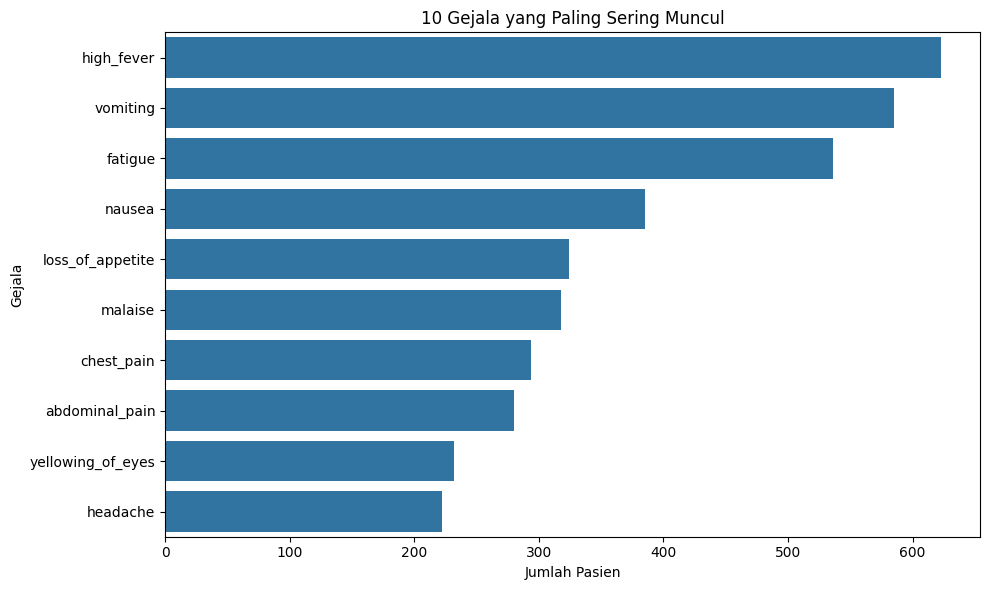

In [24]:
# ======================
# 8. Statistik Gejala
# ======================
gejala_sum = X.sum().sort_values(ascending=False)
top10_gejala = gejala_sum.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top10_gejala.values, y=top10_gejala.index)
plt.title("10 Gejala yang Paling Sering Muncul")
plt.xlabel("Jumlah Pasien")
plt.ylabel("Gejala")
plt.tight_layout()
plt.show()

In [25]:
# ======================
# 10. Naive Bayes Classifier
# ======================
print("\n=== Naive Bayes ===")
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
# Fix: Use unique labels from y_test for classification_report
print(classification_report(y_test, y_pred_nb, target_names=le.classes_[np.unique(y_test)], labels=np.unique(y_test)))


=== Naive Bayes ===
Accuracy: 0.9672131147540983
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         2
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         3
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         3
                       Bronchial Asthma       1.00      0.67      0.80         3
                   Cervical spondylosis       0.00      0.00      0.00         1
                            Chicken pox       1.00      1.00      1.00         3
                    Chronic cholestasis       1.00      1.00      1.00         2
                                 Dengue       1.00      1.00      1.00         3
                              Diabetes        1.00      1.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# ======================
# 11. Decision Tree Classifier
# ======================
print("\n=== Decision Tree ===")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, target_names=le.classes_[np.unique(y_test)], labels=np.unique(y_test)))


=== Decision Tree ===
Accuracy: 0.6721311475409836
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      0.50      0.67         2
                                   AIDS       0.00      0.00      0.00         1
                                   Acne       1.00      0.67      0.80         3
                    Alcoholic hepatitis       0.00      0.00      0.00         1
                                Allergy       1.00      0.67      0.80         3
                       Bronchial Asthma       1.00      0.67      0.80         3
                   Cervical spondylosis       0.00      0.00      0.00         1
                            Chicken pox       1.00      1.00      1.00         3
                    Chronic cholestasis       0.50      0.50      0.50         2
                                 Dengue       1.00      1.00      1.00         3
                              Diabetes        1.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# ===========================
# 12. Support Vector Machine
# ===========================
print("\n=== SVM (Linear Kernel) ===")
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_[np.unique(y_test)], labels=np.unique(y_test)))


=== SVM (Linear Kernel) ===
Accuracy: 0.9508196721311475
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         2
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         3
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         3
                       Bronchial Asthma       1.00      1.00      1.00         3
                   Cervical spondylosis       0.00      0.00      0.00         1
                            Chicken pox       1.00      1.00      1.00         3
                    Chronic cholestasis       0.67      1.00      0.80         2
                                 Dengue       1.00      1.00      1.00         3
                              Diabetes        1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
# ======================
# 13. Random Forest Classifier
# ======================
print("\n=== Random Forest ===")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_[np.unique(y_test)], labels=np.unique(y_test)))


=== Random Forest ===
Accuracy: 1.0
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         2
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         3
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         3
                       Bronchial Asthma       1.00      1.00      1.00         3
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         3
                    Chronic cholestasis       1.00      1.00      1.00         2
                                 Dengue       1.00      1.00      1.00         3
                              Diabetes        1.00      1.00      1.00 

In [30]:
# =========================================
# 14. ANN (Artificial Neural Network)
# =========================================
print("\n=== ANN (Neural Network) ===")
# One-hot encoding target
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, epochs=30, batch_size=16, verbose=0, validation_split=0.2)
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"ANN Accuracy: {accuracy:.4f}")


=== ANN (Neural Network) ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ANN Accuracy: 1.0000


In [31]:
# ======================
# 15. Simpan Hasil Akurasi Semua Model
# ======================
model_accuracies = {
    'Naive Bayes': accuracy_score(y_test, y_pred_nb),
    'Decision Tree': accuracy_score(y_test, y_pred_dt),
    'SVM': accuracy_score(y_test, y_pred_svm),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'ANN': accuracy
}

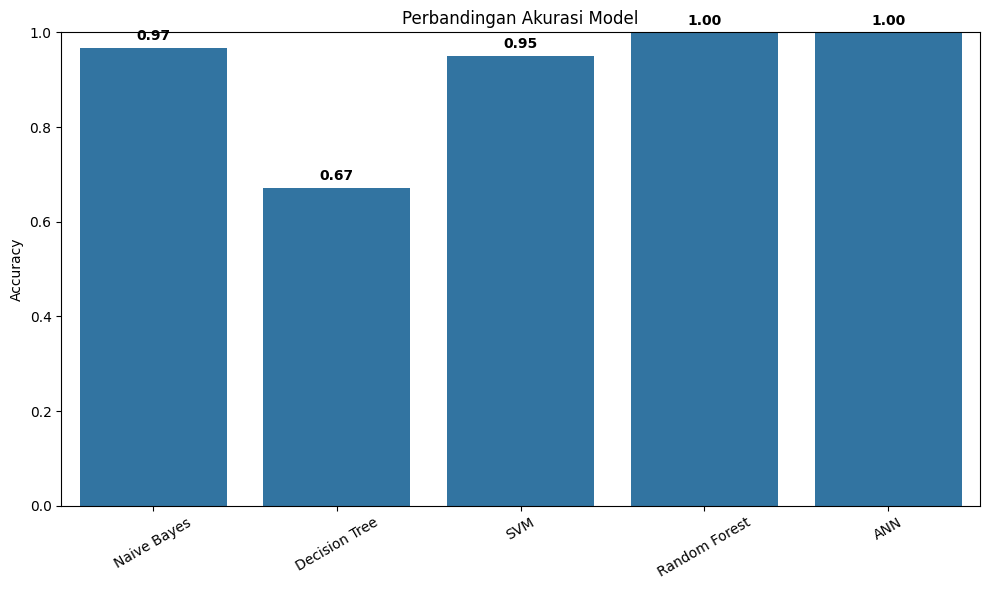

In [32]:
# ======================
# 16. Visualisasi Akurasi Model
# ======================
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()))
plt.title("Perbandingan Akurasi Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)

# Tambahkan label di atas tiap bar
for i, v in enumerate(model_accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("model_comparison_labeled.png")
plt.show()

In [ ]:
# ===============================
# 17. Menentukan Model Terbaik
# ===============================
best_model = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model]

print(f"\n✅ Model terbaik adalah: {best_model} dengan akurasi {best_accuracy:.4f}")


✅ Model terbaik adalah: Random Forest dengan akurasi 1.0000
